In [4]:
# %%
from pathlib import Path
import re
import json

# === 必填：你的文件路径 ===
XML_PATH = Path(r"E:\bridgev2_DATA\extracted_first_test_2\batch_1_annotations.xml")   # 例：/mnt/data/annotations.xml 或 E:\annotations.xml
ROOT_DIR  = Path(r"E:\bridgev2_DATA\extracted_first_test_2\batch_00001")                          # 你的图片根目录（无子文件夹）

# === 输出目录（两个独立文件夹）===
OUTPUT_PATH = Path(r"E:\bridgev2_DATA\test_traj\batch_00001") # 输出根目录
OUT_DIR_RAW  = OUTPUT_PATH / "traj_raw"        # 仅画箭头的小图
OUT_DIR_TRAJ = OUTPUT_PATH/ "traj_images"     # 3×3大图（左上角贴箭头图、其余黑）
OUT_DIR_RAW.mkdir(parents=True, exist_ok=True)
OUT_DIR_TRAJ.mkdir(parents=True, exist_ok=True)

# === 索引文件（仅 3×3 大图要求生成 JSONL）===
JSONL_TRAJ = OUTPUT_PATH / "traj_index.jsonl"

# 颜色（BGR，OpenCV）
SKYBLUE = (235, 206, 135)  # 天蓝色 (RGB 135,206,235) -> BGR
RED     = (0, 0, 255)

# 线宽和箭头参数
LINE_THICKNESS = 3
HEAD_LEN       = 13   # 菱形头沿箭向的长度（像素）
HEAD_WIDTH     = 6   # 菱形头的半宽（法向展开一半）
DIAMOND_RATIO  = 0.6  # 菱形尾点离头尖的比例（>0）


In [5]:
# %%
import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm

# —— 颜色（BGR）——
# 天蓝色：RGB(135,206,235) -> BGR(235,206,135)
SKYBLUE = (235, 206, 135)
RED     = (0, 0, 255)

# —— 文件名解析 ——（必须是 idxxxxx_step001.png）
PAT_ID_STEP = re.compile(r"^(id\d+)_step(\d+)\.png$", re.IGNORECASE)

def parse_ep_id_from_name(name: str):
    """
    从文件名解析 episode id（如 id00001_step001.png -> id00001）。
    不符合命名返回 None。
    """
    m = PAT_ID_STEP.match(name)
    return m.group(1) if m else None


In [6]:
# %%
import xml.etree.ElementTree as ET

def parse_cvat_xml_four_points(xml_path: Path):
    """
    返回 dict: image_name -> [(Ax,Ay),(Bx,By),(Cx,Cy),(Dx,Dy)]
    1) 优先使用 <polyline points="x,y;..."> 且正好 4 点
    2) 否则尝试聚合 4 个 <points points="x,y">（按出现顺序）
    """
    tree = ET.parse(str(xml_path))
    root = tree.getroot()
    name2pts = {}

    for img_tag in root.findall(".//image"):
        name = img_tag.attrib.get("name", "").strip()
        if not name:
            continue

        # 尝试 1：polyline（四点）
        poly = img_tag.find(".//polyline")
        if poly is not None:
            pts_str = poly.attrib.get("points", "").strip()
            pairs = [p.strip() for p in pts_str.split(";") if p.strip()]
            if len(pairs) == 4:
                pts = []
                ok = True
                for p in pairs:
                    try:
                        x_str, y_str = p.split(",")
                        pts.append((float(x_str), float(y_str)))
                    except:
                        ok = False
                        break
                if ok:
                    name2pts[name] = pts
                    continue  # 已记录，处理下一个 image

        # 尝试 2：四个 points
        points_nodes = img_tag.findall(".//points")
        if points_nodes and len(points_nodes) == 4:
            pts = []
            ok = True
            for node in points_nodes:
                pstr = node.attrib.get("points", "").strip()
                try:
                    x_str, y_str = pstr.split(",")
                    pts.append((float(x_str), float(y_str)))
                except:
                    ok = False
                    break
            if ok and len(pts) == 4:
                name2pts[name] = pts

    return name2pts

name2pts = parse_cvat_xml_four_points(XML_PATH)
print(f"[INFO] 从 XML 解析到 {len(name2pts)} 条带四点的图像记录。")


[INFO] 从 XML 解析到 516 条带四点的图像记录。


In [7]:
# %%
def draw_diamond_arrow(img, p0, p1, color, thickness=2, head_len=24, head_half_width=12, diamond_ratio=0.6):
    """
    在 img 上从 p0 -> p1 画“菱形箭头”（BGR）。
      - p0, p1: (x, y) 浮点/整数
      - head_len: 箭头头沿箭向长度
      - head_half_width: 箭头半宽（法向）
      - diamond_ratio: 菱形尾点后移比例（>0 则更修长）
    """
    x0, y0 = float(p0[0]), float(p0[1])
    x1, y1 = float(p1[0]), float(p1[1])

    v = np.array([x1 - x0, y1 - y0], dtype=np.float32)
    L = np.linalg.norm(v)
    if L < 1e-6:
        return
    u = v / L                           # 单位方向
    n = np.array([-u[1], u[0]], dtype=np.float32)  # 法向

    # 箭身（到头部开始位置为止）
    shaft_end = np.array([x1, y1], dtype=np.float32) - u * head_len
    cv2.line(img,
             (int(round(x0)), int(round(y0))),
             (int(round(shaft_end[0])), int(round(shaft_end[1]))),
             color=color, thickness=thickness, lineType=cv2.LINE_AA)

    # 菱形 4 点：尖 -> 右腰 -> 尾 -> 左腰
    tip     = np.array([x1, y1], dtype=np.float32)
    waist   = tip - u * head_len
    tail    = tip - u * head_len * (1.0 + diamond_ratio)
    p_right = waist + n * head_half_width
    p_left  = waist - n * head_half_width

    poly = np.array([tip, p_right, tail, p_left], dtype=np.int32).reshape(-1,1,2)
    cv2.fillPoly(img, [poly], color=color, lineType=cv2.LINE_AA)


In [8]:
# %%
# 仅匹配第一帧：_step001.png
all_imgs = sorted([p for p in ROOT_DIR.iterdir()
                   if p.is_file() and PAT_ID_STEP.match(p.name) and p.name.lower().endswith("_step001.png")])

print(f"[INFO] 发现第一帧图片 {len(all_imgs)} 张（仅处理 *_step001.png）。")

# 统计：XML 可覆盖的数量
covered = sum(1 for p in all_imgs if p.name in name2pts)
print(f"[INFO] 其中在 XML 中能找到四点记录的有 {covered} 张。")


[INFO] 发现第一帧图片 550 张（仅处理 *_step001.png）。
[INFO] 其中在 XML 中能找到四点记录的有 516 张。


In [9]:
# %%
num_saved_raw, num_skipped_raw = 0, 0

pbar = tqdm(all_imgs, desc="Generating traj_raw (arrow overlays)")

for img_path in pbar:
    fname = img_path.name
    ep_id = parse_ep_id_from_name(fname)
    if not ep_id:
        pbar.write(f"[WARN] 无法解析 id：{fname}，跳过。")
        num_skipped_raw += 1
        continue

    pts = name2pts.get(fname, None)
    if pts is None:
        pbar.write(f"[WARN] XML 无四点记录：{fname}，跳过。")
        num_skipped_raw += 1
        continue

    (A, B, C, D) = pts

    img = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
    if img is None:
        pbar.write(f"[WARN] 读取失败：{img_path}")
        num_skipped_raw += 1
        continue

    # 画两支箭
    draw_diamond_arrow(img, A, B, color=SKYBLUE,
                       thickness=LINE_THICKNESS, head_len=HEAD_LEN,
                       head_half_width=HEAD_WIDTH, diamond_ratio=DIAMOND_RATIO)
    draw_diamond_arrow(img, C, D, color=RED,
                       thickness=LINE_THICKNESS, head_len=HEAD_LEN,
                       head_half_width=HEAD_WIDTH, diamond_ratio=DIAMOND_RATIO)

    out_path = OUT_DIR_RAW / f"{ep_id}_traj_raw.png"
    if not cv2.imwrite(str(out_path), img):
        pbar.write(f"[WARN] 保存失败：{out_path}")
        num_skipped_raw += 1
        continue

    num_saved_raw += 1

pbar.close()
print(f"[DONE] traj_raw：成功 {num_saved_raw}，跳过 {num_skipped_raw}。输出目录：{OUT_DIR_RAW}")


Generating traj_raw (arrow overlays):   2%|▏         | 13/550 [00:00<00:14, 36.45it/s]

[WARN] XML 无四点记录：id00008_step001.png，跳过。
[WARN] XML 无四点记录：id00010_step001.png，跳过。


Generating traj_raw (arrow overlays):   6%|▌         | 33/550 [00:00<00:14, 34.98it/s]

[WARN] XML 无四点记录：id00028_step001.png，跳过。


Generating traj_raw (arrow overlays):   8%|▊         | 42/550 [00:01<00:14, 34.92it/s]

[WARN] XML 无四点记录：id00036_step001.png，跳过。


Generating traj_raw (arrow overlays):   9%|▉         | 50/550 [00:01<00:14, 35.17it/s]

[WARN] XML 无四点记录：id00044_step001.png，跳过。


Generating traj_raw (arrow overlays):  11%|█▏        | 62/550 [00:01<00:13, 34.99it/s]

[WARN] XML 无四点记录：id00056_step001.png，跳过。


Generating traj_raw (arrow overlays):  13%|█▎        | 71/550 [00:01<00:12, 36.93it/s]

[WARN] XML 无四点记录：id00065_step001.png，跳过。


Generating traj_raw (arrow overlays):  17%|█▋        | 92/550 [00:02<00:12, 36.44it/s]

[WARN] XML 无四点记录：id00086_step001.png，跳过。


Generating traj_raw (arrow overlays):  19%|█▊        | 103/550 [00:02<00:10, 41.79it/s]

[WARN] XML 无四点记录：id00097_step001.png，跳过。
[WARN] XML 无四点记录：id00100_step001.png，跳过。
[WARN] XML 无四点记录：id00101_step001.png，跳过。


Generating traj_raw (arrow overlays):  21%|██        | 113/550 [00:03<00:10, 40.63it/s]

[WARN] XML 无四点记录：id00110_step001.png，跳过。


Generating traj_raw (arrow overlays):  23%|██▎       | 124/550 [00:03<00:10, 42.57it/s]

[WARN] XML 无四点记录：id00119_step001.png，跳过。
[WARN] XML 无四点记录：id00123_step001.png，跳过。


Generating traj_raw (arrow overlays):  26%|██▋       | 145/550 [00:03<00:09, 40.62it/s]

[WARN] XML 无四点记录：id00137_step001.png，跳过。
[WARN] XML 无四点记录：id00138_step001.png，跳过。


Generating traj_raw (arrow overlays):  31%|███       | 168/550 [00:04<00:09, 39.88it/s]

[WARN] XML 无四点记录：id00161_step001.png，跳过。
[WARN] XML 无四点记录：id00165_step001.png，跳过。


Generating traj_raw (arrow overlays):  52%|█████▏    | 285/550 [00:07<00:06, 38.61it/s]

[WARN] XML 无四点记录：id00279_step001.png，跳过。


Generating traj_raw (arrow overlays):  59%|█████▊    | 322/550 [00:08<00:06, 37.53it/s]

[WARN] XML 无四点记录：id00316_step001.png，跳过。


Generating traj_raw (arrow overlays):  64%|██████▍   | 352/550 [00:09<00:05, 38.59it/s]

[WARN] XML 无四点记录：id00344_step001.png，跳过。
[WARN] XML 无四点记录：id00347_step001.png，跳过。


Generating traj_raw (arrow overlays):  69%|██████▉   | 380/550 [00:10<00:04, 35.98it/s]

[WARN] XML 无四点记录：id00377_step001.png，跳过。


Generating traj_raw (arrow overlays):  71%|███████   | 389/550 [00:10<00:04, 37.20it/s]

[WARN] XML 无四点记录：id00385_step001.png，跳过。


Generating traj_raw (arrow overlays):  74%|███████▍  | 406/550 [00:11<00:03, 37.38it/s]

[WARN] XML 无四点记录：id00399_step001.png，跳过。


Generating traj_raw (arrow overlays):  76%|███████▌  | 417/550 [00:11<00:03, 43.16it/s]

[WARN] XML 无四点记录：id00408_step001.png，跳过。
[WARN] XML 无四点记录：id00412_step001.png，跳过。
[WARN] XML 无四点记录：id00415_step001.png，跳过。


Generating traj_raw (arrow overlays):  83%|████████▎ | 456/550 [00:12<00:02, 36.36it/s]

[WARN] XML 无四点记录：id00451_step001.png，跳过。


Generating traj_raw (arrow overlays):  90%|█████████ | 497/550 [00:13<00:01, 37.94it/s]

[WARN] XML 无四点记录：id00493_step001.png，跳过。
[WARN] XML 无四点记录：id00498_step001.png，跳过。


Generating traj_raw (arrow overlays):  96%|█████████▌| 528/550 [00:14<00:00, 38.40it/s]

[WARN] XML 无四点记录：id00522_step001.png，跳过。
[WARN] XML 无四点记录：id00525_step001.png，跳过。


Generating traj_raw (arrow overlays): 100%|█████████▉| 549/550 [00:14<00:00, 36.77it/s]

[WARN] XML 无四点记录：id00543_step001.png，跳过。


Generating traj_raw (arrow overlays): 100%|██████████| 550/550 [00:14<00:00, 36.69it/s]

[DONE] traj_raw：成功 516，跳过 34。输出目录：E:\bridgev2_DATA\test_traj\batch_00001\traj_raw


In [10]:
# %%
# 先清空/新建 JSONL
with open(JSONL_TRAJ, "w", encoding="utf-8") as jf:
    pass

num_saved_traj, num_skipped_traj = 0, 0

pbar = tqdm(all_imgs, desc="Generating traj (3x3 corner)")

for img_path in pbar:
    fname = img_path.name
    ep_id = parse_ep_id_from_name(fname)
    if not ep_id:
        pbar.write(f"[WARN] 无法解析 id：{fname}，跳过。")
        num_skipped_traj += 1
        continue

    # 对应的小图（traj_raw）应已生成
    raw_img_path = OUT_DIR_RAW / f"{ep_id}_traj_raw.png"
    if not raw_img_path.exists():
        pbar.write(f"[WARN] 缺少 traj_raw：{raw_img_path.name}，跳过。")
        num_skipped_traj += 1
        continue

    # 读入小图（RGB），计算尺寸
    img_bgr = cv2.imread(str(raw_img_path), cv2.IMREAD_COLOR)
    if img_bgr is None:
        pbar.write(f"[WARN] 读取失败：{raw_img_path}")
        num_skipped_traj += 1
        continue

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    h, w = img_rgb.shape[:2]

    # 建 3×3 黑底 (w*3, h*3)，左上角粘贴已画箭头的小图
    big_img = Image.new("RGB", (w*3, h*3), color=(0, 0, 0))
    big_img.paste(Image.fromarray(img_rgb), (0, 0))

    out_path = OUT_DIR_TRAJ / f"{ep_id}_traj.png"
    big_img.save(out_path)

    # 写 JSONL（source 为相对 OUT_DIR_TRAJ 的相对路径）
    rec = {"idx": ep_id, "source": str(out_path.relative_to(OUT_DIR_TRAJ))}
    with open(JSONL_TRAJ, "a", encoding="utf-8") as jf:
        jf.write(json.dumps(rec, ensure_ascii=False) + "\n")

    num_saved_traj += 1

pbar.close()
print(f"[DONE] traj：成功 {num_saved_traj}，跳过 {num_skipped_traj}。输出目录：{OUT_DIR_TRAJ}")
print(f"[DONE] 索引写入：{JSONL_TRAJ}")


Generating traj (3x3 corner):   2%|▏         | 12/550 [00:00<00:21, 24.78it/s]

[WARN] 缺少 traj_raw：id00008_traj_raw.png，跳过。
[WARN] 缺少 traj_raw：id00010_traj_raw.png，跳过。


Generating traj (3x3 corner):   5%|▌         | 30/550 [00:01<00:23, 22.47it/s]

[WARN] 缺少 traj_raw：id00028_traj_raw.png，跳过。


Generating traj (3x3 corner):   7%|▋         | 39/550 [00:01<00:23, 22.07it/s]

[WARN] 缺少 traj_raw：id00036_traj_raw.png，跳过。


Generating traj (3x3 corner):   8%|▊         | 46/550 [00:02<00:22, 22.83it/s]

[WARN] 缺少 traj_raw：id00044_traj_raw.png，跳过。


Generating traj (3x3 corner):  11%|█         | 58/550 [00:02<00:22, 21.86it/s]

[WARN] 缺少 traj_raw：id00056_traj_raw.png，跳过。


Generating traj (3x3 corner):  12%|█▏        | 67/550 [00:03<00:21, 22.06it/s]

[WARN] 缺少 traj_raw：id00065_traj_raw.png，跳过。


Generating traj (3x3 corner):  16%|█▌        | 88/550 [00:04<00:21, 21.79it/s]

[WARN] 缺少 traj_raw：id00086_traj_raw.png，跳过。


Generating traj (3x3 corner):  18%|█▊        | 100/550 [00:04<00:18, 24.17it/s]

[WARN] 缺少 traj_raw：id00097_traj_raw.png，跳过。
[WARN] 缺少 traj_raw：id00100_traj_raw.png，跳过。
[WARN] 缺少 traj_raw：id00101_traj_raw.png，跳过。


Generating traj (3x3 corner):  20%|██        | 112/550 [00:05<00:18, 23.38it/s]

[WARN] 缺少 traj_raw：id00110_traj_raw.png，跳过。


Generating traj (3x3 corner):  22%|██▏       | 121/550 [00:05<00:19, 21.92it/s]

[WARN] 缺少 traj_raw：id00119_traj_raw.png，跳过。
[WARN] 缺少 traj_raw：id00123_traj_raw.png，跳过。


Generating traj (3x3 corner):  25%|██▌       | 140/550 [00:06<00:16, 24.36it/s]

[WARN] 缺少 traj_raw：id00137_traj_raw.png，跳过。
[WARN] 缺少 traj_raw：id00138_traj_raw.png，跳过。


Generating traj (3x3 corner):  30%|██▉       | 164/550 [00:07<00:18, 21.16it/s]

[WARN] 缺少 traj_raw：id00161_traj_raw.png，跳过。
[WARN] 缺少 traj_raw：id00165_traj_raw.png，跳过。


Generating traj (3x3 corner):  51%|█████▏    | 283/550 [00:13<00:12, 21.47it/s]

[WARN] 缺少 traj_raw：id00279_traj_raw.png，跳过。


Generating traj (3x3 corner):  58%|█████▊    | 319/550 [00:15<00:10, 21.47it/s]

[WARN] 缺少 traj_raw：id00316_traj_raw.png，跳过。


Generating traj (3x3 corner):  63%|██████▎   | 349/550 [00:16<00:08, 23.81it/s]

[WARN] 缺少 traj_raw：id00344_traj_raw.png，跳过。
[WARN] 缺少 traj_raw：id00347_traj_raw.png，跳过。


Generating traj (3x3 corner):  69%|██████▉   | 379/550 [00:18<00:08, 21.37it/s]

[WARN] 缺少 traj_raw：id00377_traj_raw.png，跳过。


Generating traj (3x3 corner):  71%|███████   | 388/550 [00:18<00:07, 21.90it/s]

[WARN] 缺少 traj_raw：id00385_traj_raw.png，跳过。


Generating traj (3x3 corner):  73%|███████▎  | 403/550 [00:19<00:06, 21.76it/s]

[WARN] 缺少 traj_raw：id00399_traj_raw.png，跳过。


Generating traj (3x3 corner):  75%|███████▍  | 412/550 [00:19<00:05, 24.76it/s]

[WARN] 缺少 traj_raw：id00408_traj_raw.png，跳过。
[WARN] 缺少 traj_raw：id00412_traj_raw.png，跳过。


Generating traj (3x3 corner):  76%|███████▌  | 419/550 [00:19<00:05, 24.14it/s]

[WARN] 缺少 traj_raw：id00415_traj_raw.png，跳过。


Generating traj (3x3 corner):  82%|████████▏ | 452/550 [00:21<00:04, 22.21it/s]

[WARN] 缺少 traj_raw：id00451_traj_raw.png，跳过。


Generating traj (3x3 corner):  90%|█████████ | 495/550 [00:23<00:02, 22.85it/s]

[WARN] 缺少 traj_raw：id00493_traj_raw.png，跳过。


Generating traj (3x3 corner):  91%|█████████ | 501/550 [00:23<00:02, 22.47it/s]

[WARN] 缺少 traj_raw：id00498_traj_raw.png，跳过。


Generating traj (3x3 corner):  96%|█████████▌| 526/550 [00:24<00:00, 24.75it/s]

[WARN] 缺少 traj_raw：id00522_traj_raw.png，跳过。
[WARN] 缺少 traj_raw：id00525_traj_raw.png，跳过。


Generating traj (3x3 corner):  99%|█████████▉| 545/550 [00:25<00:00, 22.80it/s]

[WARN] 缺少 traj_raw：id00543_traj_raw.png，跳过。


Generating traj (3x3 corner): 100%|██████████| 550/550 [00:26<00:00, 21.10it/s]

[DONE] traj：成功 516，跳过 34。输出目录：E:\bridgev2_DATA\test_traj\batch_00001\traj_images
[DONE] 索引写入：E:\bridgev2_DATA\test_traj\batch_00001\traj_index.jsonl


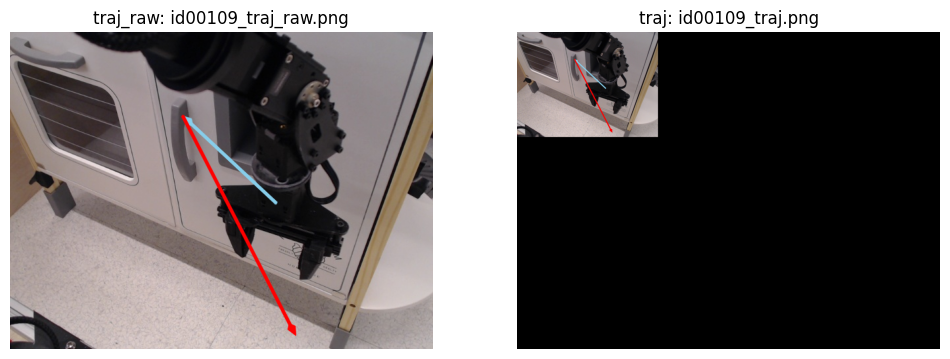

In [11]:
# %%
import random
import matplotlib.pyplot as plt

# 收集已产出的 ep_id
produced_ids = [parse_ep_id_from_name(p.name) for p in sorted(all_imgs)
                if (OUT_DIR_RAW / f"{parse_ep_id_from_name(p.name) or 'NONE'}_traj_raw.png").exists()
                and (OUT_DIR_TRAJ / f"{parse_ep_id_from_name(p.name) or 'NONE'}_traj.png").exists()]
produced_ids = [eid for eid in produced_ids if eid is not None]

if not produced_ids:
    print("[INFO] 尚未产出可预览的样本。请先运行上面的生成单元格。")
else:
    ep_id = random.choice(produced_ids)
    raw_path  = OUT_DIR_RAW  / f"{ep_id}_traj_raw.png"
    traj_path = OUT_DIR_TRAJ / f"{ep_id}_traj.png"

    raw_rgb  = cv2.cvtColor(cv2.imread(str(raw_path)),  cv2.COLOR_BGR2RGB)
    traj_rgb = cv2.cvtColor(cv2.imread(str(traj_path)), cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1); plt.imshow(raw_rgb);  plt.title(f"traj_raw: {raw_path.name}");  plt.axis('off')
    plt.subplot(1,2,2); plt.imshow(traj_rgb); plt.title(f"traj: {traj_path.name}");    plt.axis('off')
    plt.show()


In [14]:
# ==== 参数路径 ====
jsonl_b = Path(r"F:\PangYe\bridgev2_DATA\extracted_nine_test\composed_index.jsonl")     # B 含 idx, target, text
jsonl_a = Path(r"E:\bridgev2_DATA\test_traj\batch_00001\traj_index.jsonl")   # A 含 idx, source

output_jsonl = Path(r"E:\bridgev2_DATA\test_traj\batch_00001\merged_index.jsonl") # 合并输出
missing_log   = Path(r"E:\bridgev2_DATA\test_traj\batch_00001\missing_records.txt") # 缺失记录日志（可选）

# ==== 读取 JSONL A ====
records_a = {}
with open(jsonl_a, "r", encoding="utf-8") as fa:
    for line in fa:
        rec = json.loads(line)
        idx = rec.get("idx")
        if idx:
            records_a[idx] = rec
print(f"[INFO] 从 A 读取 {len(records_a)} 条记录。")

# ==== 读取 JSONL B ====
records_b = {}
with open(jsonl_b, "r", encoding="utf-8") as fb:
    for line in fb:
        rec = json.loads(line)
        idx = rec.get("idx")
        if idx:
            records_b[idx] = rec
print(f"[INFO] 从 B 读取 {len(records_b)} 条记录。")

# ==== 合并逻辑 ====
merged = []
missing_a, missing_b = [], []

for idx in tqdm(sorted(set(records_a) | set(records_b)), desc="Merging (skip incomplete)"):
    in_a, in_b = idx in records_a, idx in records_b

    if in_a and in_b:
        rec_a = records_a[idx]
        rec_b = records_b[idx]
        merged_rec = dict(rec_a)
        merged_rec.update(rec_b)
        merged.append(merged_rec)
    elif in_a and not in_b:
        missing_b.append(idx)
    elif in_b and not in_a:
        missing_a.append(idx)

# ==== 写出合并结果 ====
with open(output_jsonl, "w", encoding="utf-8") as fout:
    for rec in merged:
        fout.write(json.dumps(rec, ensure_ascii=False) + "\n")

# ==== 写出缺失记录日志 ====
with open(missing_log, "w", encoding="utf-8") as flog:
    flog.write("=== 缺少于 A 的样本（存在于 B 但不在 A） ===\n")
    for idx in missing_a:
        flog.write(idx + "\n")
    flog.write("\n=== 缺少于 B 的样本（存在于 A 但不在 B） ===\n")
    for idx in missing_b:
        flog.write(idx + "\n")

# ==== 汇总信息 ====
print("\n✅ 合并完成：")
print(f"  - 写入 {len(merged)} 条有效记录 → {output_jsonl}")
print(f"  - A 独有（B 缺失）：{len(missing_b)} 条")
print(f"  - B 独有（A 缺失）：{len(missing_a)} 条")
print(f"  - 缺失日志：{missing_log}")


[INFO] 从 A 读取 516 条记录。
[INFO] 从 B 读取 3475 条记录。


Merging (skip incomplete): 100%|██████████| 3475/3475 [00:00<00:00, 2332779.51it/s]


✅ 合并完成：
  - 写入 516 条有效记录 → E:\bridgev2_DATA\test_traj\batch_00001\merged_index.jsonl
  - A 独有（B 缺失）：0 条
  - B 独有（A 缺失）：2959 条
  - 缺失日志：E:\bridgev2_DATA\test_traj\batch_00001\missing_records.txt


In [15]:
# %%
import json
from tqdm import tqdm
from pathlib import Path

# ==== 输入 / 输出路径 ====
input_jsonl  = Path(r"E:\bridgev2_DATA\test_traj\batch_00001\merged_index.jsonl")
output_jsonl = Path(r"E:\bridgev2_DATA\test_traj\batch_00001\test_index.jsonl")

# ==== 新的 text 字段内容 ====
new_text = "A 3x3 grid image to inpaint the blank black cells: only the top-left cell shows the real scene with arrows indicating the start and end of the trajectory."

# ==== 逐行读取、替换并写出 ====
count = 0
with open(input_jsonl, "r", encoding="utf-8") as fin, open(output_jsonl, "w", encoding="utf-8") as fout:
    for line in tqdm(fin, desc="Replacing text field"): 
        line = line.strip()
        if not line:
            continue
        try:
            rec = json.loads(line)
        except json.JSONDecodeError as e:
            print(f"[WARN] 跳过无效 JSON 行：{e}")
            continue

        # 替换或添加 text 字段
        rec["text"] = new_text
        fout.write(json.dumps(rec, ensure_ascii=False) + "\n")
        count += 1

print(f"\n✅ 已处理 {count} 条记录，输出文件：{output_jsonl}")
# c/root/PhotoDoodle/data/bridge_train/AAA_merged_index_text_replaced_batch00001.jsonl

Replacing text field: 516it [00:00, 102942.39it/s]


✅ 已处理 516 条记录，输出文件：E:\bridgev2_DATA\test_traj\batch_00001\test_index.jsonl
